## this script is based on the W1D4 tutorial 2 logistic regression decoder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import hashlib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
#Helper functions taken from the tutorial

def plot_weights(models, sharey=True):
    """Draw a stem plot of weights for each model in models dict."""
    n = len(models)
    f = plt.figure(figsize=(10, 2.5 * n))
    axs = f.subplots(n, sharex=True, sharey=sharey)
    axs = np.atleast_1d(axs)
    for ax, (title, model) in zip(axs, models.items()):
        ax.margins(x=.02)
        stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
        stem[0].set_marker(".")
        stem[0].set_color(".2")
        stem[1].set_linewidths(.5)
        stem[1].set_color(".2")
        stem[2].set_visible(False)
        ax.axhline(0, color="C3", lw=3)
        ax.set(ylabel="Weight", title=title)
    ax.set(xlabel="Neuron (a.k.a. feature)")
    f.tight_layout()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )

def plot_model_selection(C_values, accuracies):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, accuracies, marker="o")
    best_C = C_values[np.argmax(accuracies)]
    ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
    )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, non_zero_l1, marker="o")
    ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
    )
    ax.axhline(n_voxels, color=".1", linestyle=":")
    ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

def sigmoid(z):
    return 1 / (1+np.exp(-z))

# download the steinmetz dataset used in the tutorial

In [4]:
url = "https://osf.io/r9gh8/download"
fname = "W1D4_steinmetz_data.npz"
expected_md5 = "d19716354fed0981267456b80db07ea8"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)


In [5]:
def load_steinmetz_data(data_fname=fname):
    with np.load(data_fname) as dobj:
        data = dict(**dobj)
    return data

# Load data

In [6]:
#this is sample data provided in tutorial
data = load_steinmetz_data()
for key, val in data.items():
    print(key, val.shape)

spikes (276, 691)
choices (276,)


In [18]:
#OUR DATA
y = data["choices"] #these are the binary choices the animal made on each trial (trialnr)
X = data["spikes"] #these are the mean spike rates for each neuron (trialnr x neurons)

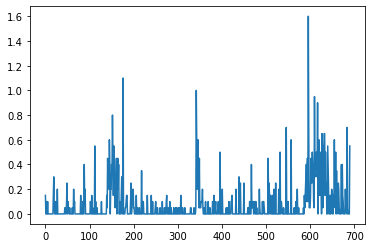

In [20]:
plt.figure
plt.plot(X[0,:])

# fit logistic regression models

In [21]:
# First define the model
log_reg = LogisticRegression(penalty='none',solver='newton-cg')

#Then fit it to data
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
#get accuracy of the model on the training set (should be high!)
y_pred = log_reg.predict(X)
train_accuracy = np.mean(y_pred == y)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


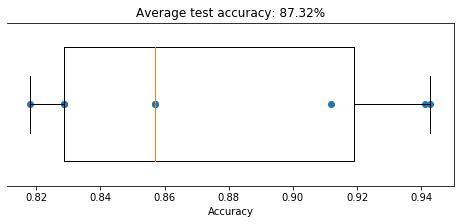

In [23]:
#get accuracy of the model on a k-fold cross validated set

k=8 #choose k-fold
reg = 'l2' #choose regularization. 'none', 'l1', or 'l2'
lam = 1 #choose lambda for regularizer

#fit model
#log_reg = LogisticRegression(penalty='none').fit(X, y)
log_reg = LogisticRegression(penalty=reg, C=1/lam, solver='lbfgs').fit(X, y)

#get cross-validated accuracies
accuracies = cross_val_score(log_reg, X, y, cv=k)

#plot the resulting accuracies
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones_like(accuracies))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [29]:
def model_selection(X, y, C_values, CV_values):
    """Compute CV accuracy for each C value.

    Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values

    Returns:
    accuracies (1D array): CV accuracy with each value of C

    """
    accuracies_all = []

    for CV in CV_values:

        accuracies = []

        for C in C_values:

            # Initialize and fit the model
            model = LogisticRegression(penalty='l2',C=C, solver='lbfgs',max_iter=5000)
            model.fit(X,y)

            # Get the accuracy for each test split
            accs = cross_val_score(model,X,y,cv=int(CV))

            # Store the average test accuracy for this value of C
            accuracies.append(np.mean(accs))

        accuracies_all.append(accuracies)

    return accuracies_all



# Use log-spaced values for C and CV

C_values = np.logspace(-4, 4, 9)

#CV_values = np.linspace(2,20,10)
CV_values = np.logspace(1,7,7,base=2)
#CV_values = np.logspace(np.arange(2,50,2)

accuracies_all = model_selection(X, y, C_values, CV_values)

In [ ]:
#plot results
ax = plt.figure().subplots()
ax.set_xscale("log")
cmap = plt.cm.get_cmap('coolwarm')
for i,accuracies in enumerate(accuracies_all):
    c = cmap(i/(len(accuracies_all)-1))
    ax.plot(C_values, accuracies, marker="o",color=c)
    best_C = C_values[np.argmax(accuracies)]
    plt.text(1,0.8-0.02*i,f"{CV_values[i]:1g}-fold CV: Cmax={best_C:1g}",color=c)
ax.set(
  xticks=C_values,
  xlabel="$C$",
  ylabel="Cross-validated accuracy",
)